# 0.0 IMPORTS

In [1]:
import pandas as pd
import seaborn as sns
import umap.umap_ as umap
import numpy as np
import re
import sqlite3
from sqlalchemy import create_engine


import sweetviz
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from scipy.cluster import hierarchy as hc
from sklearn.decomposition import PCA
from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import preprocessing as pp
from sklearn import ensemble as en
from sklearn.neighbors import NearestNeighbors
from sklearn import mixture as mx
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from IPython.display       import Image

ModuleNotFoundError: No module named 'umap'

## 0.1. Auxiliar Functions

In [2]:
def jupyter_settings():
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 10]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None

    sns.set()


## 0.2. Load Data

In [3]:
data_raw = pd.read_csv('datasets/Ecommerce.csv', encoding = 'unicode_escape')

data_raw = data_raw.drop(columns = ['Unnamed: 8'])

# 1.0. Data Description

In [4]:
df1 = data_raw.copy()

## 1.1. Rename Columns

In [5]:
df1.columns = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

## 1.2. Data Dimensions

In [6]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of cols: {df1.shape[1]}')

Number of rows: 541909
Number of cols: 8


## 1.3. Data Types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [8]:
df1.isnull().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [9]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [10]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [11]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change Types

In [12]:
# invoice data
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype('int64')

## 1.7. Descriptive Statistics

In [13]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [14]:
min_      = pd.DataFrame(num_attributes.apply(np.min)).T
max_      = pd.DataFrame(num_attributes.apply(np.max)).T
mean_     = pd.DataFrame(num_attributes.apply(np.mean)).T
median_   = pd.DataFrame(num_attributes.apply(np.median)).T
std_      = pd.DataFrame(num_attributes.apply(np.std)).T
range_    = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
skew_     = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis_ = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
data_statistical = pd.concat([min_, max_, range_, mean_, median_, std_, skew_, kurtosis_]).T.reset_index()
data_statistical.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [15]:
data_statistical

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


#### 1.7.1.1 Numerical Attributes - Investigating

1. Negative Quantity (Devolution?)
2. Unit Price == 0 (Sales Promotion?)

### 1.7.2 Categorical Attributes

In [16]:
# INVOICE NUMBER

#cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'invoice_no'].drop_duplicates()
len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'invoice_no'].drop_duplicates())

3839

In [17]:
# STOCK CODE

#at_leat_one_string = len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'stock_code'])
#at_leat_one_string

#cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()
df1.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
45,536370,POST,POSTAGE,3,2016-11-29,18.00,France,12583
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
386,536403,POST,POSTAGE,1,2016-11-29,15.00,Netherlands,12791
1123,536527,POST,POSTAGE,1,2016-11-29,18.00,Germany,12662
1814,536544,DOT,DOTCOM POSTAGE,1,2016-11-29,569.77,United Kingdom,19001


# 2.0. Data Filtering

In [18]:
df2 = df1.copy()

In [19]:
# Numerical Attributes #
# Unit price > 0.0
df2 = df2.loc[df2['unit_price'] > 0.04, :]

# stock code != [POST, D, M, DOT, CRUK]
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'DOT', 'CRUK', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B'])]

# description
df2 = df2.drop(columns='description', axis=1)

# map
df2 = df2[~df2['country'].isin( [ 'European Community', 'Unspecified'] )]

# bad users
df2 = df2[~df2['customer_id'].isin([16466])]

## quantity - Negative numbers means product returns
df_returns = df2.loc[df2['quantity'] < 0, :]
df_purchase = df2.loc[df2['quantity'] > 0, :]

In [20]:
#df2.loc[df2['quantity'] < 0, :].sort_values(['customer_id', 'description']).head()
#df2.loc[df2['invoice_no'].apply(lambda x: bool(re.search('.540152', x))), :].head()
#df2.loc[df2['customer_id'] == 12395, :].sort_values('description')

# 3.0. Feature Engineering

In [21]:
df3 = df2.copy()

In [22]:
df3.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850


## 3.1. Feature Creation

In [23]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis = 1).drop_duplicates(ignore_index=True)

### 3.1.1 Gross Revenue

In [24]:
# Gross Revenue (Faturamento)
df_purchase.loc[:, 'gross_revenue'] = df_purchase.loc[:, 'quantity'] * df_purchase.loc[:, 'unit_price']

# Monetary
df_monetary = df_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

c:\Users\Victor\Desktop\repos\pa005_clustering\clustering\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\Victor\Desktop\repos\pa005_clustering\clustering\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### 3.1.2 Recency - Day from last purchase

In [25]:
# Recency - Last day purchase
df_recency = df_purchase[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()

df_recency['recency_days'] = (df_purchase['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()

df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

### 3.1.3 Quantity of purchased

In [26]:
# Frequency
df_freq = (df_purchase[['customer_id', 'invoice_no']].drop_duplicates()
                                                    .groupby('customer_id')
                                                    .count()
                                                    .reset_index()
                                                    .rename(columns={'invoice_no':'qtde_invoices'}))


df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

### 3.1.4 Quantity of items purchased

In [27]:
# Frequency
df_freq = (df_purchase[['customer_id', 'quantity']].groupby('customer_id')
                                                  .sum()
                                                  .reset_index()
                                                  .rename(columns={'quantity':'qtd_items'}))

df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

### 3.1.5 Quantity of stock purchased

In [28]:
# Frequency
df_freq = (df_purchase[['customer_id', 'stock_code']].groupby('customer_id')
                                                  .count()
                                                  .reset_index()
                                                  .rename(columns={'stock_code':'qtd_products'}))

df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

### 3.1.6 Average Ticket Value

In [29]:
# Avg Ticket
avg_ticket = df_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue' : 'avg_ticket'})
df_ref = pd.merge(df_ref, avg_ticket, on='customer_id', how='left')

### 3.1.7 Average Recency Days

In [30]:
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=[False, False])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoice date

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis = 1).dropna()

# average recency
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left')

### 3.1.8 Frequency Purchase

In [31]:
df_aux = (df2[['invoice_no', 'customer_id', 'invoice_date']].drop_duplicates()
                                                            .groupby('customer_id')
                                                            .agg(max_ = ('invoice_date', 'max'),
                                                                 min_ = ('invoice_date', 'min'),
                                                                 days = ('invoice_date', lambda x: (( x.max() - x.min()).days) +1),
                                                                 buy_ = ('invoice_date', 'count'))).reset_index()

# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days']].apply(lambda x: x['buy_'] / x['days'] if x['days'] != 0 else 0, axis = 1)

df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

### 3.1.9 Number of Returns

In [32]:
df2_returns = df_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtde_returns'})
df2_returns['qtde_returns'] = df2_returns['qtde_returns'] * -1
df_ref = pd.merge(df_ref, df2_returns, how='left', on='customer_id')
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

### 3.1.10 Basket Size - Quantidade de items por cesta

In [33]:
df_aux = (df_purchase.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                         .agg(n_purchase=('invoice_no', 'nunique'),
                                                                              n_products=('quantity', 'sum')).reset_index())

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id')

### 3.1.11 Unique Basket Size

In [34]:
df_aux = (df_purchase.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                         .agg(n_purchase=('invoice_no', 'nunique'),
                                                                              n_products=('stock_code', 'nunique')).reset_index())

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id')

# 4.0. EDA

In [35]:
df4 = df_ref.dropna().copy()

## 4.1. Univariate Analysis

**Notes**

1. Clusters Coesos - Separados
2. Métricas
    - Min, Máximo, Range(Dispersão)
    - Média e Mediana
    - Desvio Padrão e Variância
    - Coeficiente de Variação (CV)
    - Distribuição

In [36]:
#my_report = sweetviz.analyze(df4)
#my_report.show_html('Report.html')

### 4.1.1 Gross Revenue

In [37]:
 df4.sort_values( 'gross_revenue', ascending=False ).head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,-7.844444,0.206215,288.0,2733.944444,9.708333
492,18102,259657.30,0.0,60.0,64124.0,431.0,602.453132,-14.680000,0.163043,0.0,1068.733333,2.500000
433,17450,194550.79,8.0,46.0,69993.0,337.0,577.302047,-12.821429,0.136111,952.0,1521.586957,2.695652
3337,16446,168472.50,0.0,2.0,80997.0,3.0,56157.500000,-205.000000,0.014563,80995.0,40498.500000,1.500000
66,14911,140438.72,1.0,199.0,79963.0,5670.0,24.768734,-2.601399,0.651475,3332.0,401.824121,8.969849


In [38]:
df4[df4['customer_id'] == 14646]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,-7.844444,0.206215,288.0,2733.944444,9.708333


### 4.1.2 Qtde Items

In [39]:
df4[df4['qtd_products'] == 7838]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size


### 4.1.3 Avg items

In [40]:
df4[df4['avg_ticket'] == 56157.5]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
3337,16446,168472.5,0.0,2.0,80997.0,3.0,56157.5,-205.0,0.014563,80995.0,40498.5,1.5


## 4.2. Bivariate Analysis

In [41]:
#plt.figure(figsize=(25, 12))
#sns.pairplot(df4[['gross_revenue', 'avg_ticket', 'frequency', 'avg_recency_days', 'recency_days', 'qtde_invoices', 'qtde_returns', 'avg_basket_size']]);

## 4.3. Estudo do Espaço

In [42]:
#df43 = df4.drop(columns=['customer_id'], axis=1).copy()
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtd_products', 'frequency', 'qtde_returns']
df43 = df4[cols_selected].copy()

In [43]:
mms = pp.MinMaxScaler()

In [44]:
df43['gross_revenue']          = mms.fit_transform(df43[['gross_revenue']])
df43['recency_days']           = mms.fit_transform(df43[['recency_days']])
#df43['qtde_invoices']          = mms.fit_transform(df43[['qtde_invoices']])
df43['qtd_products']           = mms.fit_transform(df43[['qtd_products']])
#df43['avg_ticket']             = mms.fit_transform(df43[['avg_ticket']])
#df43['avg_recency_days']       = mms.fit_transform(df43[['avg_recency_days']])
df43['frequency']              = mms.fit_transform(df43[['frequency']])
df43['qtde_returns']           = mms.fit_transform(df43[['qtde_returns']])
#df43['avg_basket_size']        = mms.fit_transform(df43[['avg_basket_size']])
#df43['avg_unique_basket_size'] = mms.fit_transform(df43[['avg_unique_basket_size']])

In [45]:
X = df43.copy()

In [46]:
X.shape

(2968, 6)

### 4.3.1 PCA

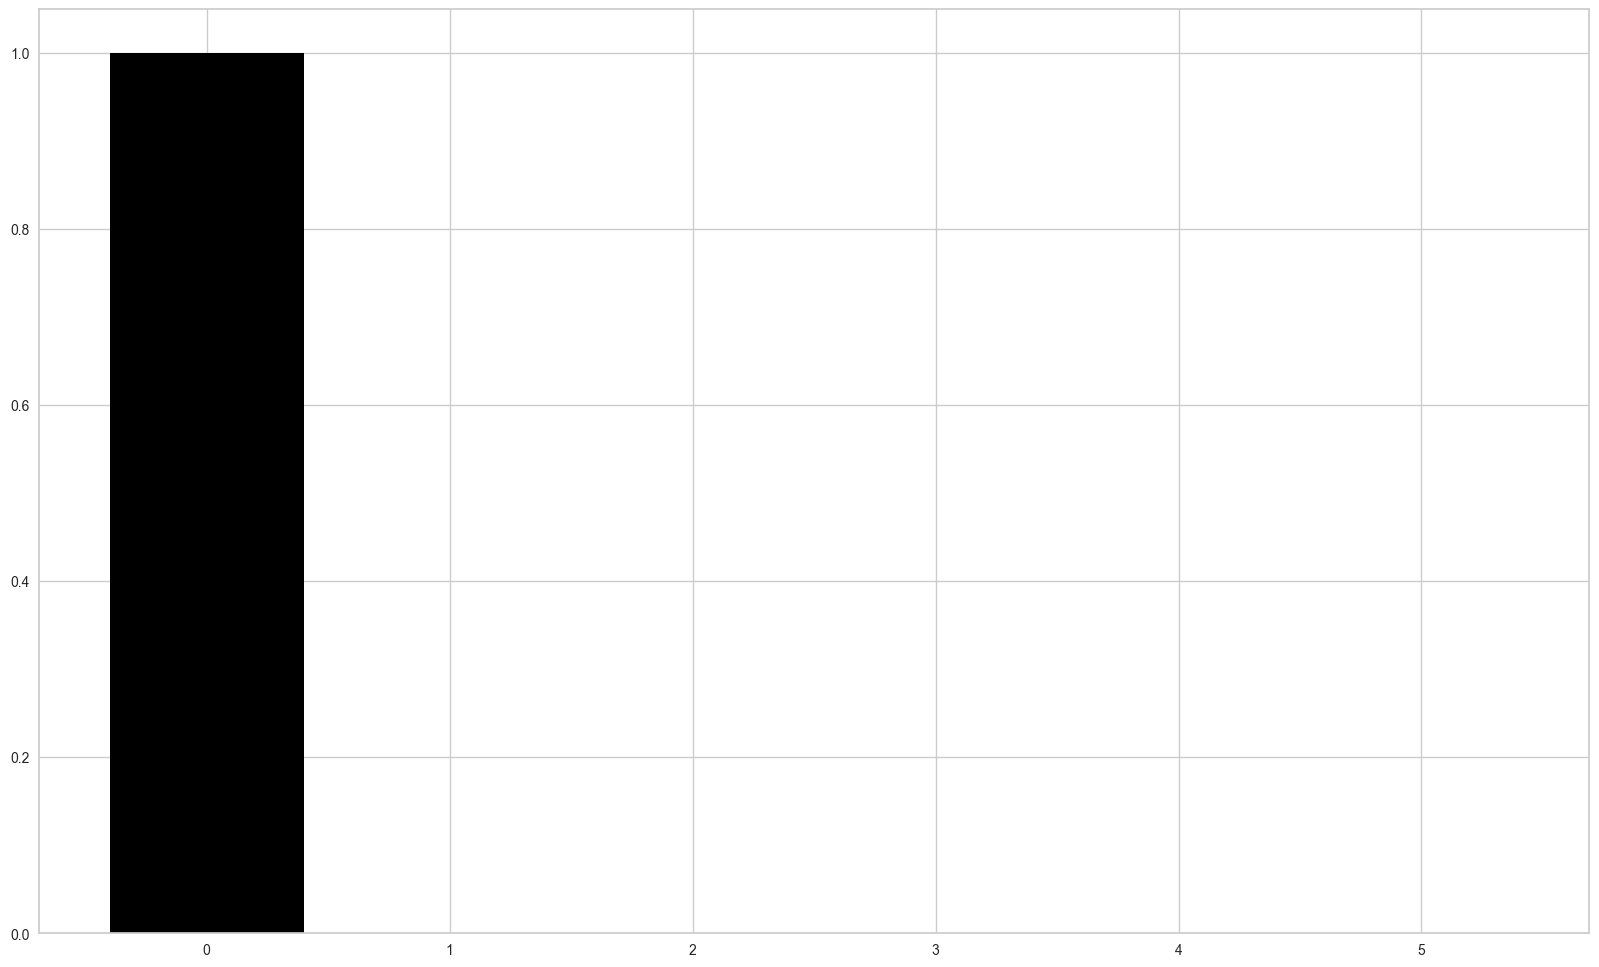

In [47]:
pca = PCA(n_components=X.shape[1])
principal_component = pca.fit_transform(X)

# plot explained variable
features = range(pca.n_components_)
plt.figure(figsize=(20,12))
plt.bar(features, pca.explained_variance_ratio_, color='black')

# pca component
df_pca = pd.DataFrame(principal_component)

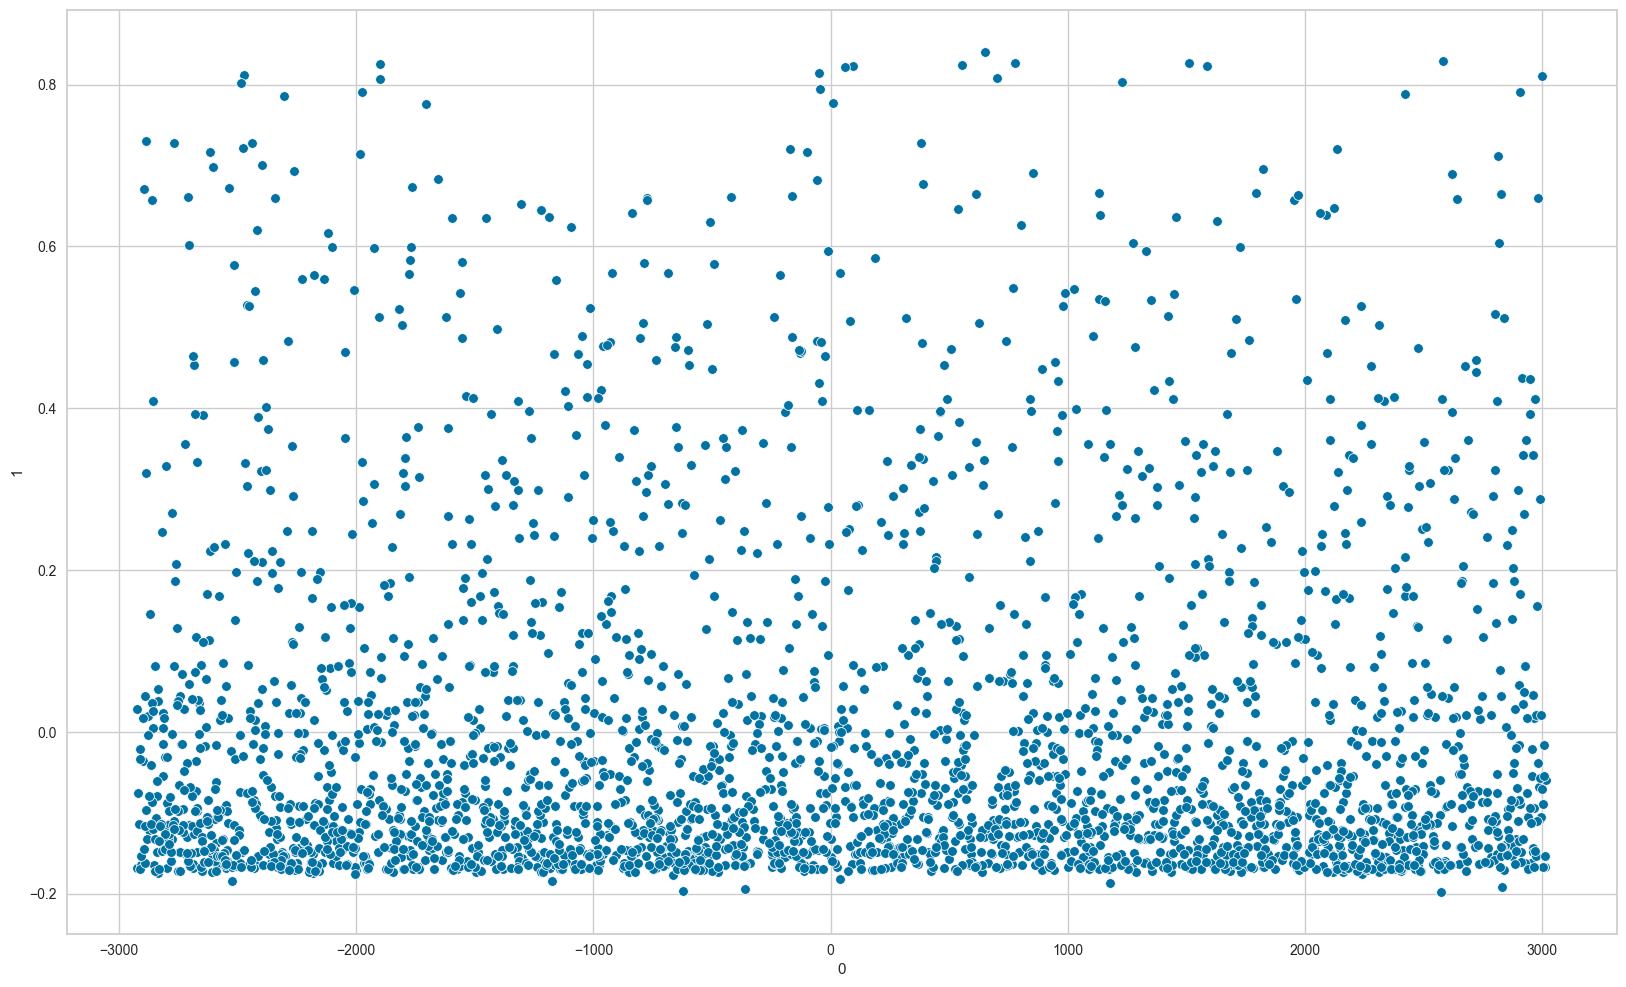

In [48]:
plt.figure(figsize=(20, 12))
sns.scatterplot(x=0, y=1, data=df_pca);

### 4.3.2 UMAP

c:\Users\Victor\Desktop\repos\pa005_clustering\clustering\lib\site-packages\numba\np\ufunc\parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

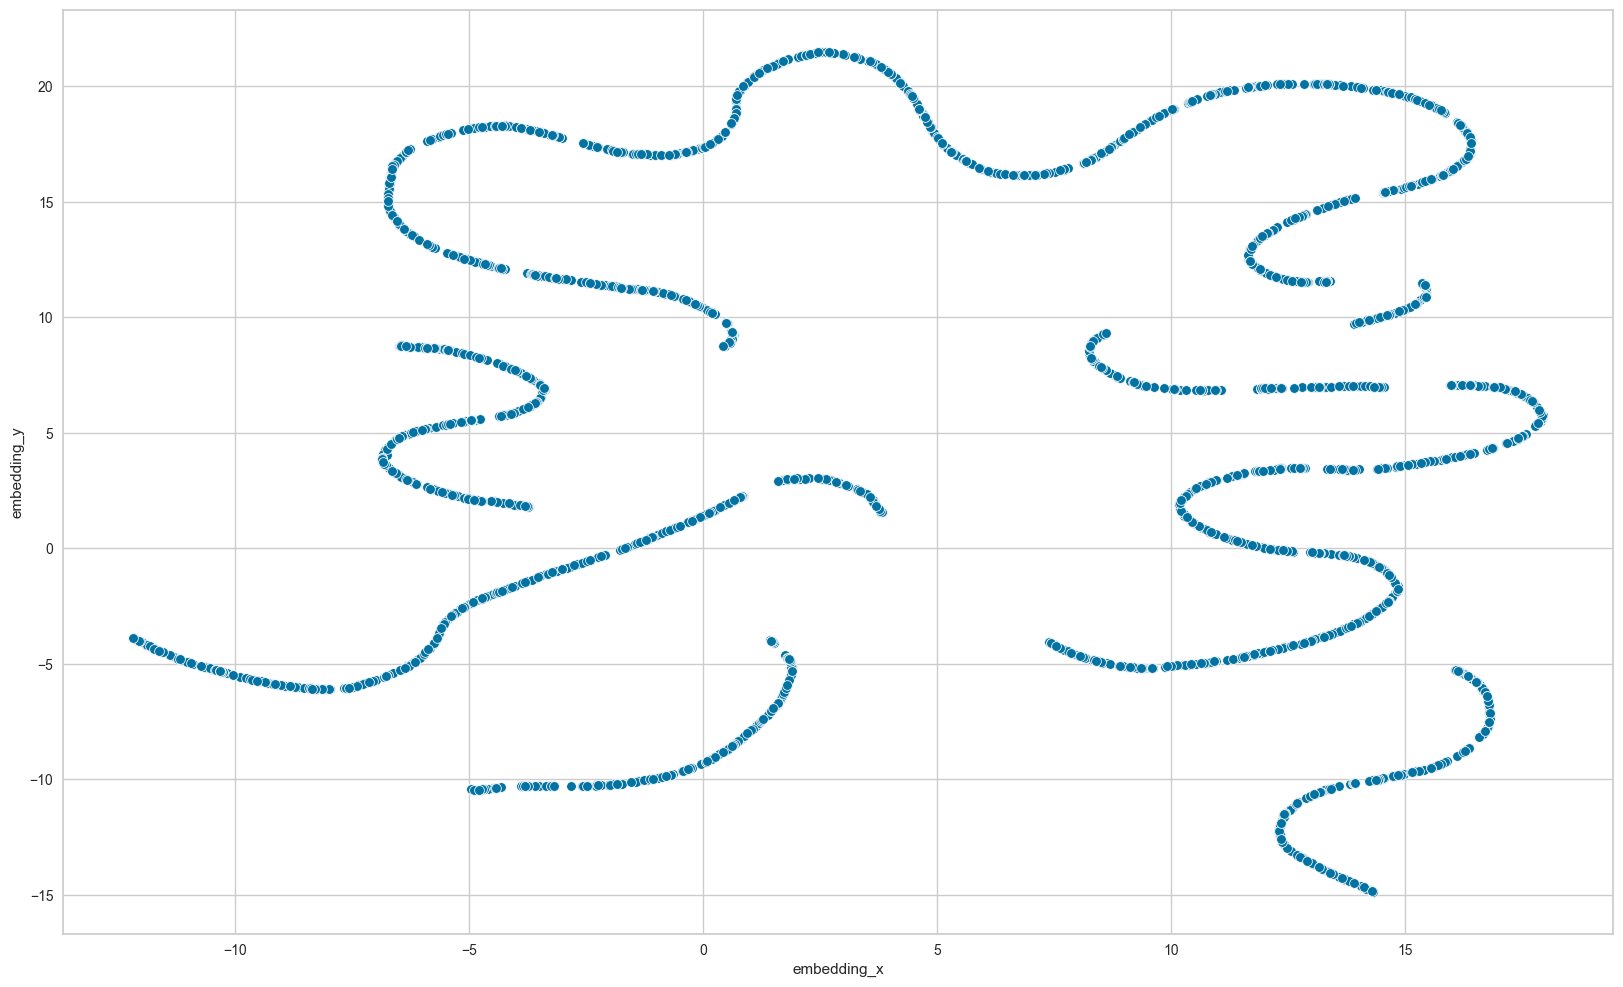

In [49]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot
plt.figure(figsize=(20,12))
sns.scatterplot(x='embedding_x', y='embedding_y', data = df_pca)

### 4.3.3 t-SNE

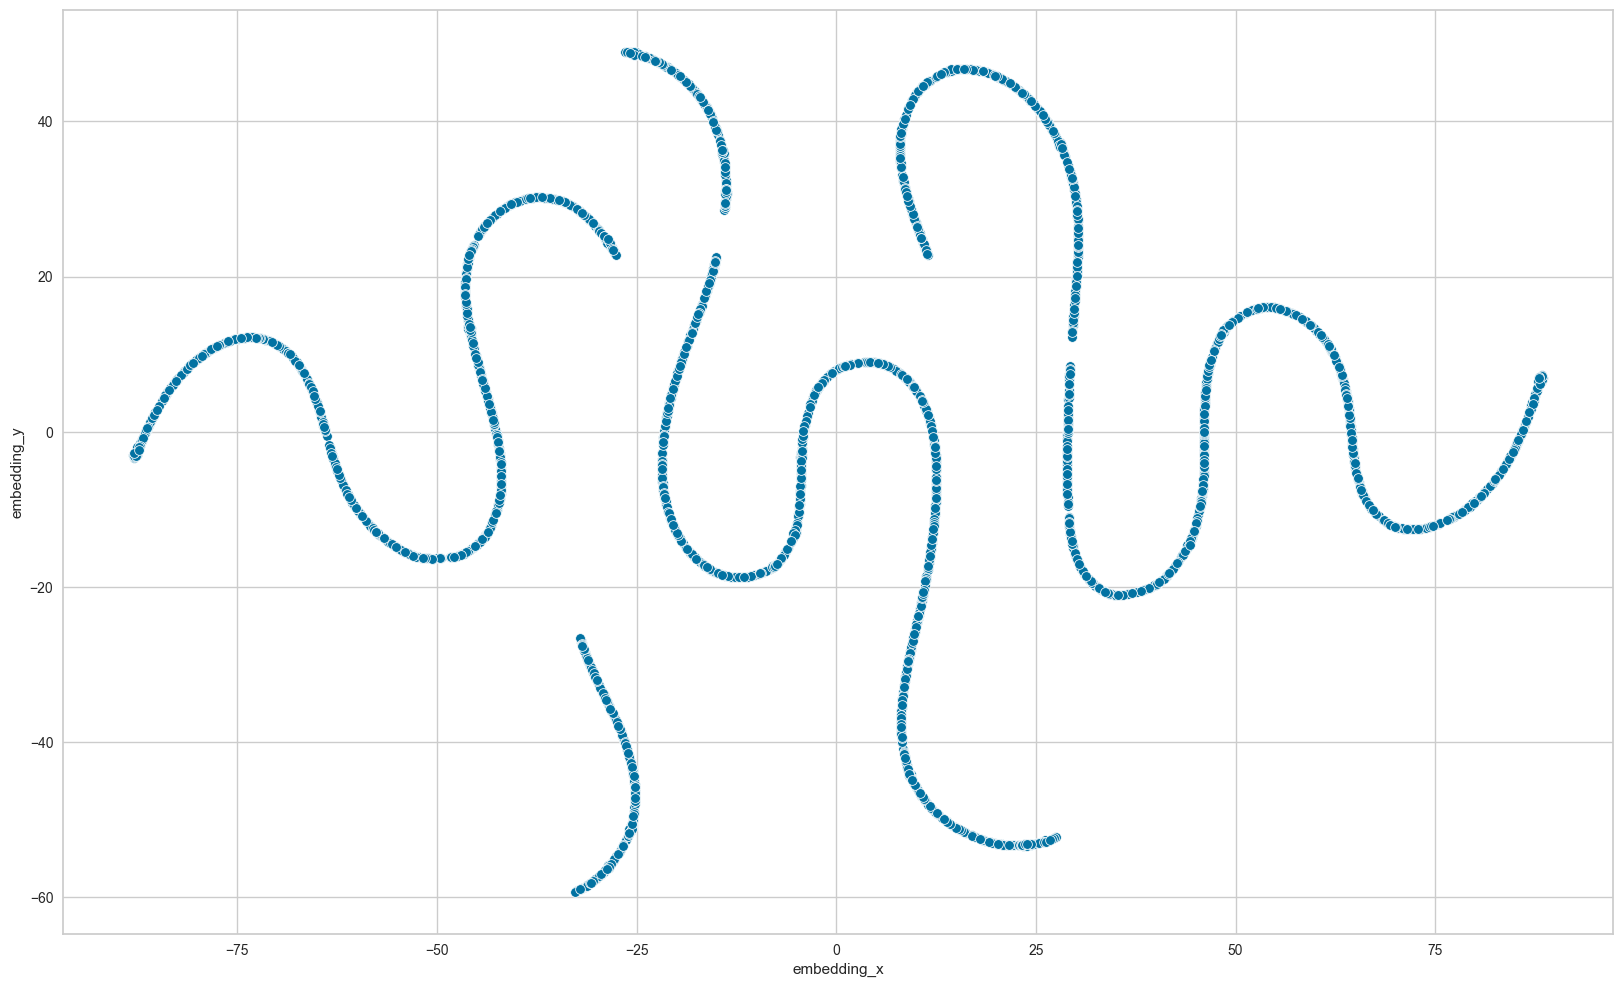

In [50]:
reducer = TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot
plt.figure(figsize=(20,12))
sns.scatterplot(x='embedding_x', y='embedding_y', data = df_pca);

### 4.3.4 Tree Based Embedding

In [51]:
X = df4.drop(columns=['customer_id', 'gross_revenue'], axis = 1)
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X, y)

# Leaf
df_leaf = pd.DataFrame(rf_model.apply(X))


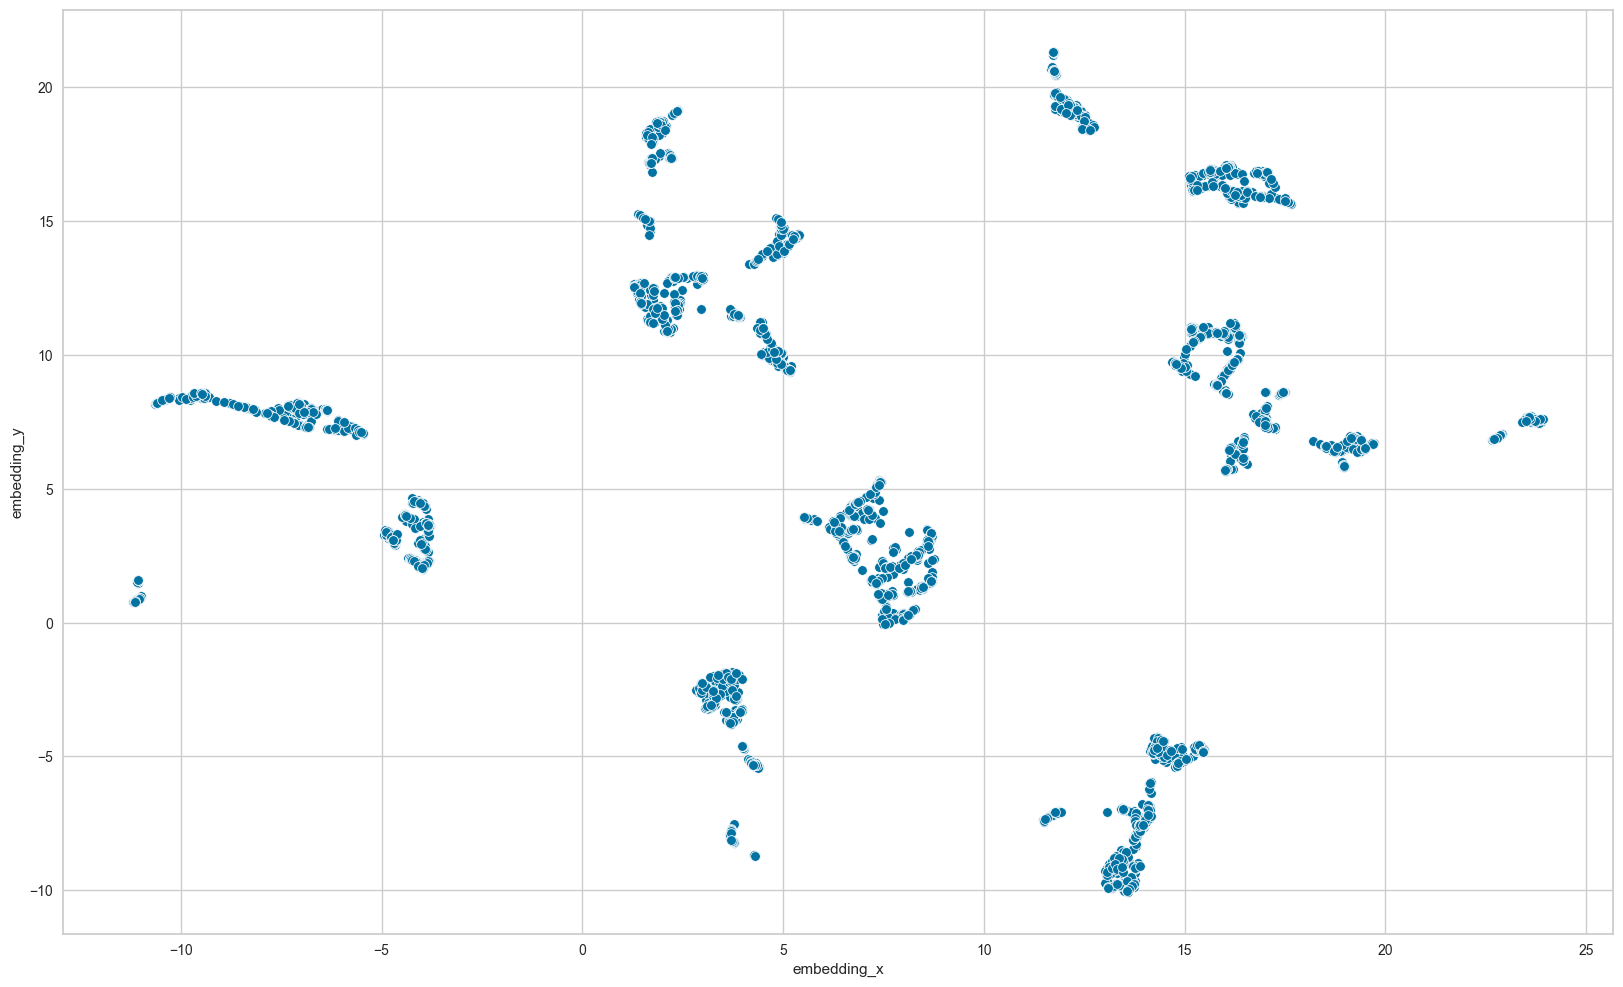

In [52]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot
plt.figure(figsize=(20,12))
sns.scatterplot(x='embedding_x', y='embedding_y', data = df_tree);

# 5.0. Data Preparation

In [53]:
#df5_aux = df4.copy()
df5 = df_tree.copy()

In [54]:
#ss = pp.StandardScaler()
#mm = pp.MinMaxScaler()
#rs = pp.RobustScaler()
#
#df5['gross_revenue'] = mm.fit_transform(df5[['gross_revenue']])
#df5['recency_days'] = mm.fit_transform(df5[['recency_days']])
#df5['qtde_invoices'] = mm.fit_transform(df5[['qtde_invoices']])
#df5['qtd_products'] = mm.fit_transform(df5[['qtd_products']])
#df5['avg_ticket'] = mm.fit_transform(df5[['avg_ticket']])
#df5['avg_recency_days'] = mm.fit_transform(df5[['avg_recency_days']])
#df5['frequency'] = mm.fit_transform(df5[['frequency']])
#df5['qtde_returns'] = mm.fit_transform(df5[['qtde_returns']])
#df5['avg_basket_size'] = mm.fit_transform(df5[['avg_basket_size']])
#df5['avg_unique_basket_size'] = mm.fit_transform(df5[['avg_unique_basket_size']])
#df5['qtd_items'] = mm.fit_transform(df5[['qtd_items']])
#
#variable = 'qtde_invoices'

# 6.0. Feature Selection

In [55]:
#cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtd_products', 'frequency', 'qtde_returns']
df6 = df_tree.copy()

# 7.0. Hyperparameter Fine Tunning

In [56]:
#X = df6.drop(columns=['customer_id'])
X = df_tree.copy()
#clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
clusters = np.arange(2, 25, 1)

In [57]:
X.head()

,embedding_x,embedding_y
0,11.751369,21.327261
1,15.552561,16.329659
2,-8.372342,8.039770
3,3.789669,-8.210548
4,1.656555,14.489147


## 7.3. GMM

In [58]:
gmm_list = []
# model definition
for k in clusters:
    gmm_model = mx.GaussianMixture(n_components=k)

    # model training
    gmm_model.fit(X)
    
    # model predict
    labels = gmm_model.predict(X)

    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

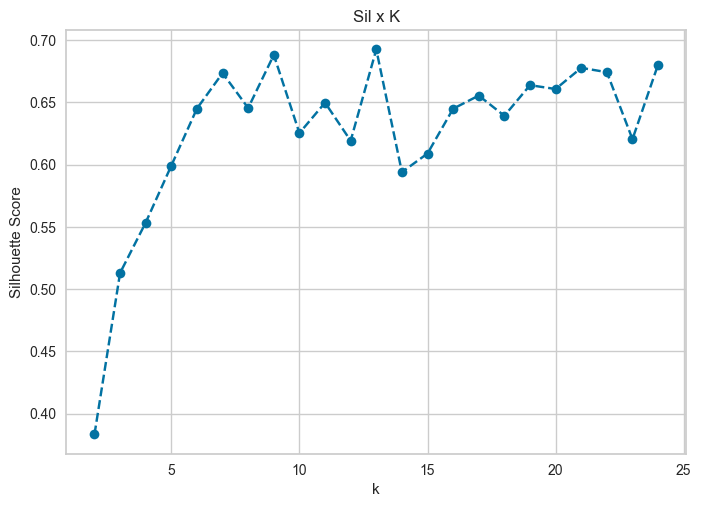

In [59]:
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Sil x K');

## 7.4. Hierarchical Clustering

In [60]:
hc_model = hc.linkage(X, 'ward')

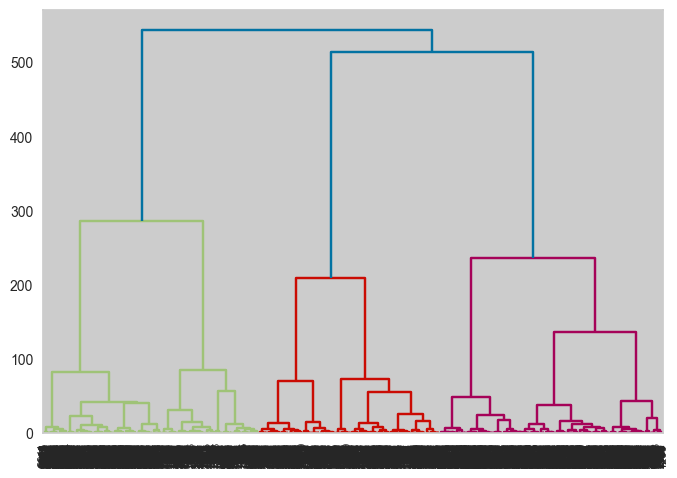

In [61]:
hc.dendrogram(hc_model,
              leaf_rotation=90,
              leaf_font_size=8)

plt.show();

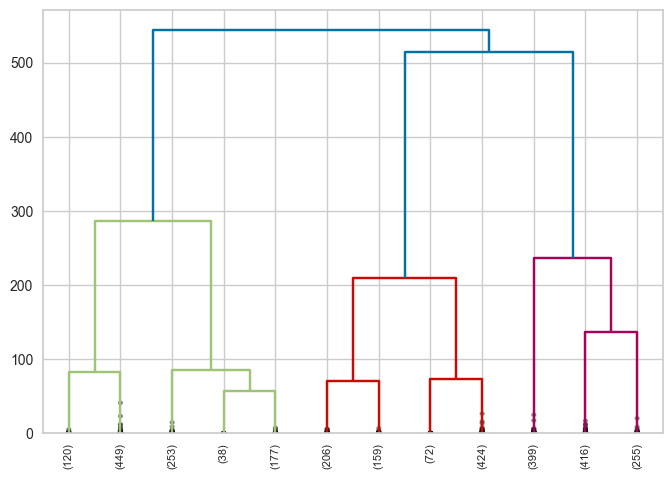

In [62]:
hc.dendrogram(hc_model,
              truncate_mode='lastp',
              p=12,
              leaf_rotation=90,
              leaf_font_size=8,
              show_contracted=True)

plt.show();

In [63]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage(X, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # metrics
    sil = m.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)

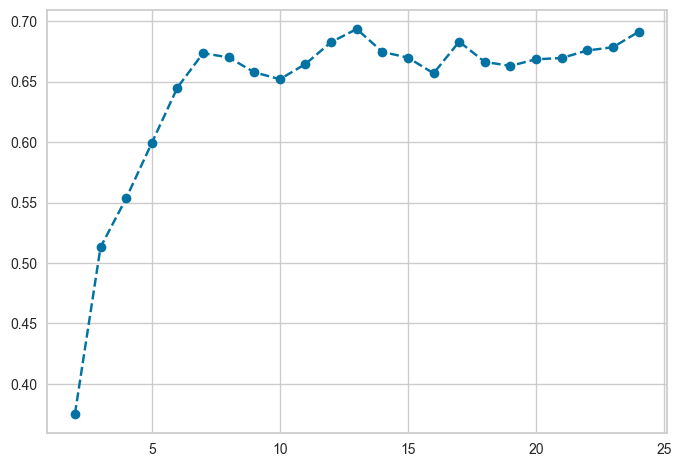

In [64]:
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b')

## 7.5. DBSCAN

In [65]:
eps=2.0
min_samples=20

# model definition
dbscan_model = c.DBSCAN(eps=eps, min_samples=min_samples)

# model training and predict
labels = dbscan_model.fit_predict(X)

sil = m.silhouette_score(X, labels, metric='euclidean')
print('Silhoette Score: {}'.format(sil))
print('Number of Clusters: {}'.format(len(np.unique(labels))))
print(np.unique(labels))

Silhoette Score: 0.6839007139205933
Number of Clusters: 12
[ 0  1  2  3  4  5  6  7  8  9 10 11]


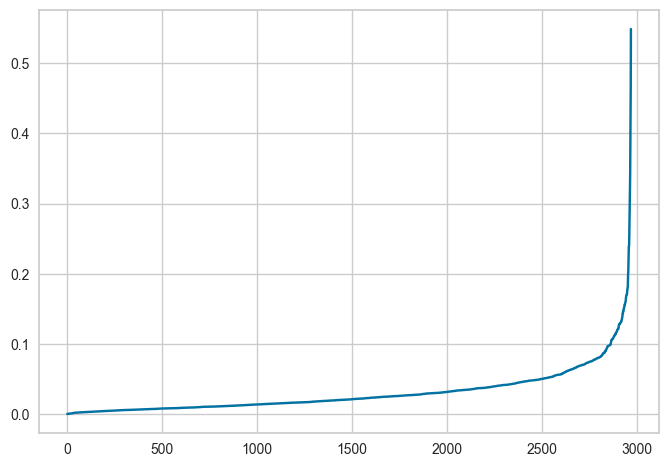

In [66]:
neighbors = NearestNeighbors(n_neighbors=min_samples).fit(X)
distances, indices = neighbors.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.plot(distances);

In [67]:
dbscan_list = [0.632589, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

## 7.6. Kmeans

In [68]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(n_init = 10, n_clusters=k)

    # model training
    kmeans_model.fit(X)

    # model predict
    labels = kmeans_model.predict(X)

    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil);

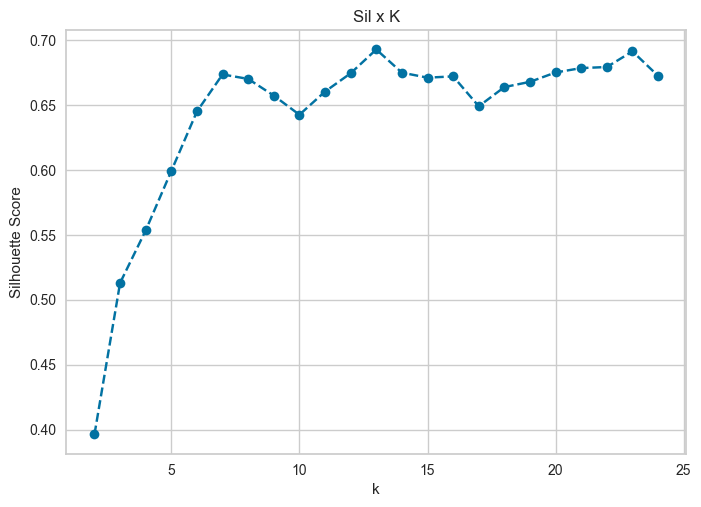

In [69]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Sil x K');

## 7.7. Results

In [70]:
df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
     'GMM': gmm_list,
     'HC': hc_list}
     #'DBScan': dbscan_list}
).T

df_results.columns = clusters

In [71]:
df_results.style.highlight_max(color='lightgreen', axis = 1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.396372,0.513028,0.553462,0.599239,0.645078,0.673567,0.670110,0.657260,0.642542,0.660382,0.674461,0.692789,0.674946,0.671088,0.672065,0.649059,0.663838,0.667871,0.675095,0.678459,0.679286,0.691335,0.672440
GMM,0.383284,0.513028,0.553462,0.599239,0.645078,0.673567,0.645533,0.688176,0.625394,0.649813,0.619234,0.692548,0.593997,0.608964,0.644955,0.655522,0.639256,0.663867,0.660781,0.677772,0.674306,0.620476,0.680455
HC,0.374992,0.513028,0.553462,0.599239,0.645078,0.673567,0.670110,0.657806,0.652024,0.664633,0.682721,0.693566,0.674649,0.669916,0.656926,0.683126,0.666320,0.663086,0.668525,0.669577,0.675819,0.678484,0.691224


For K = 2. Silhouette Score: 0.3749922811985016
For K = 3. Silhouette Score: 0.5130283832550049
For K = 4. Silhouette Score: 0.5534622669219971
For K = 5. Silhouette Score: 0.5992394685745239
For K = 6. Silhouette Score: 0.6450775265693665
For K = 7. Silhouette Score: 0.6735671162605286


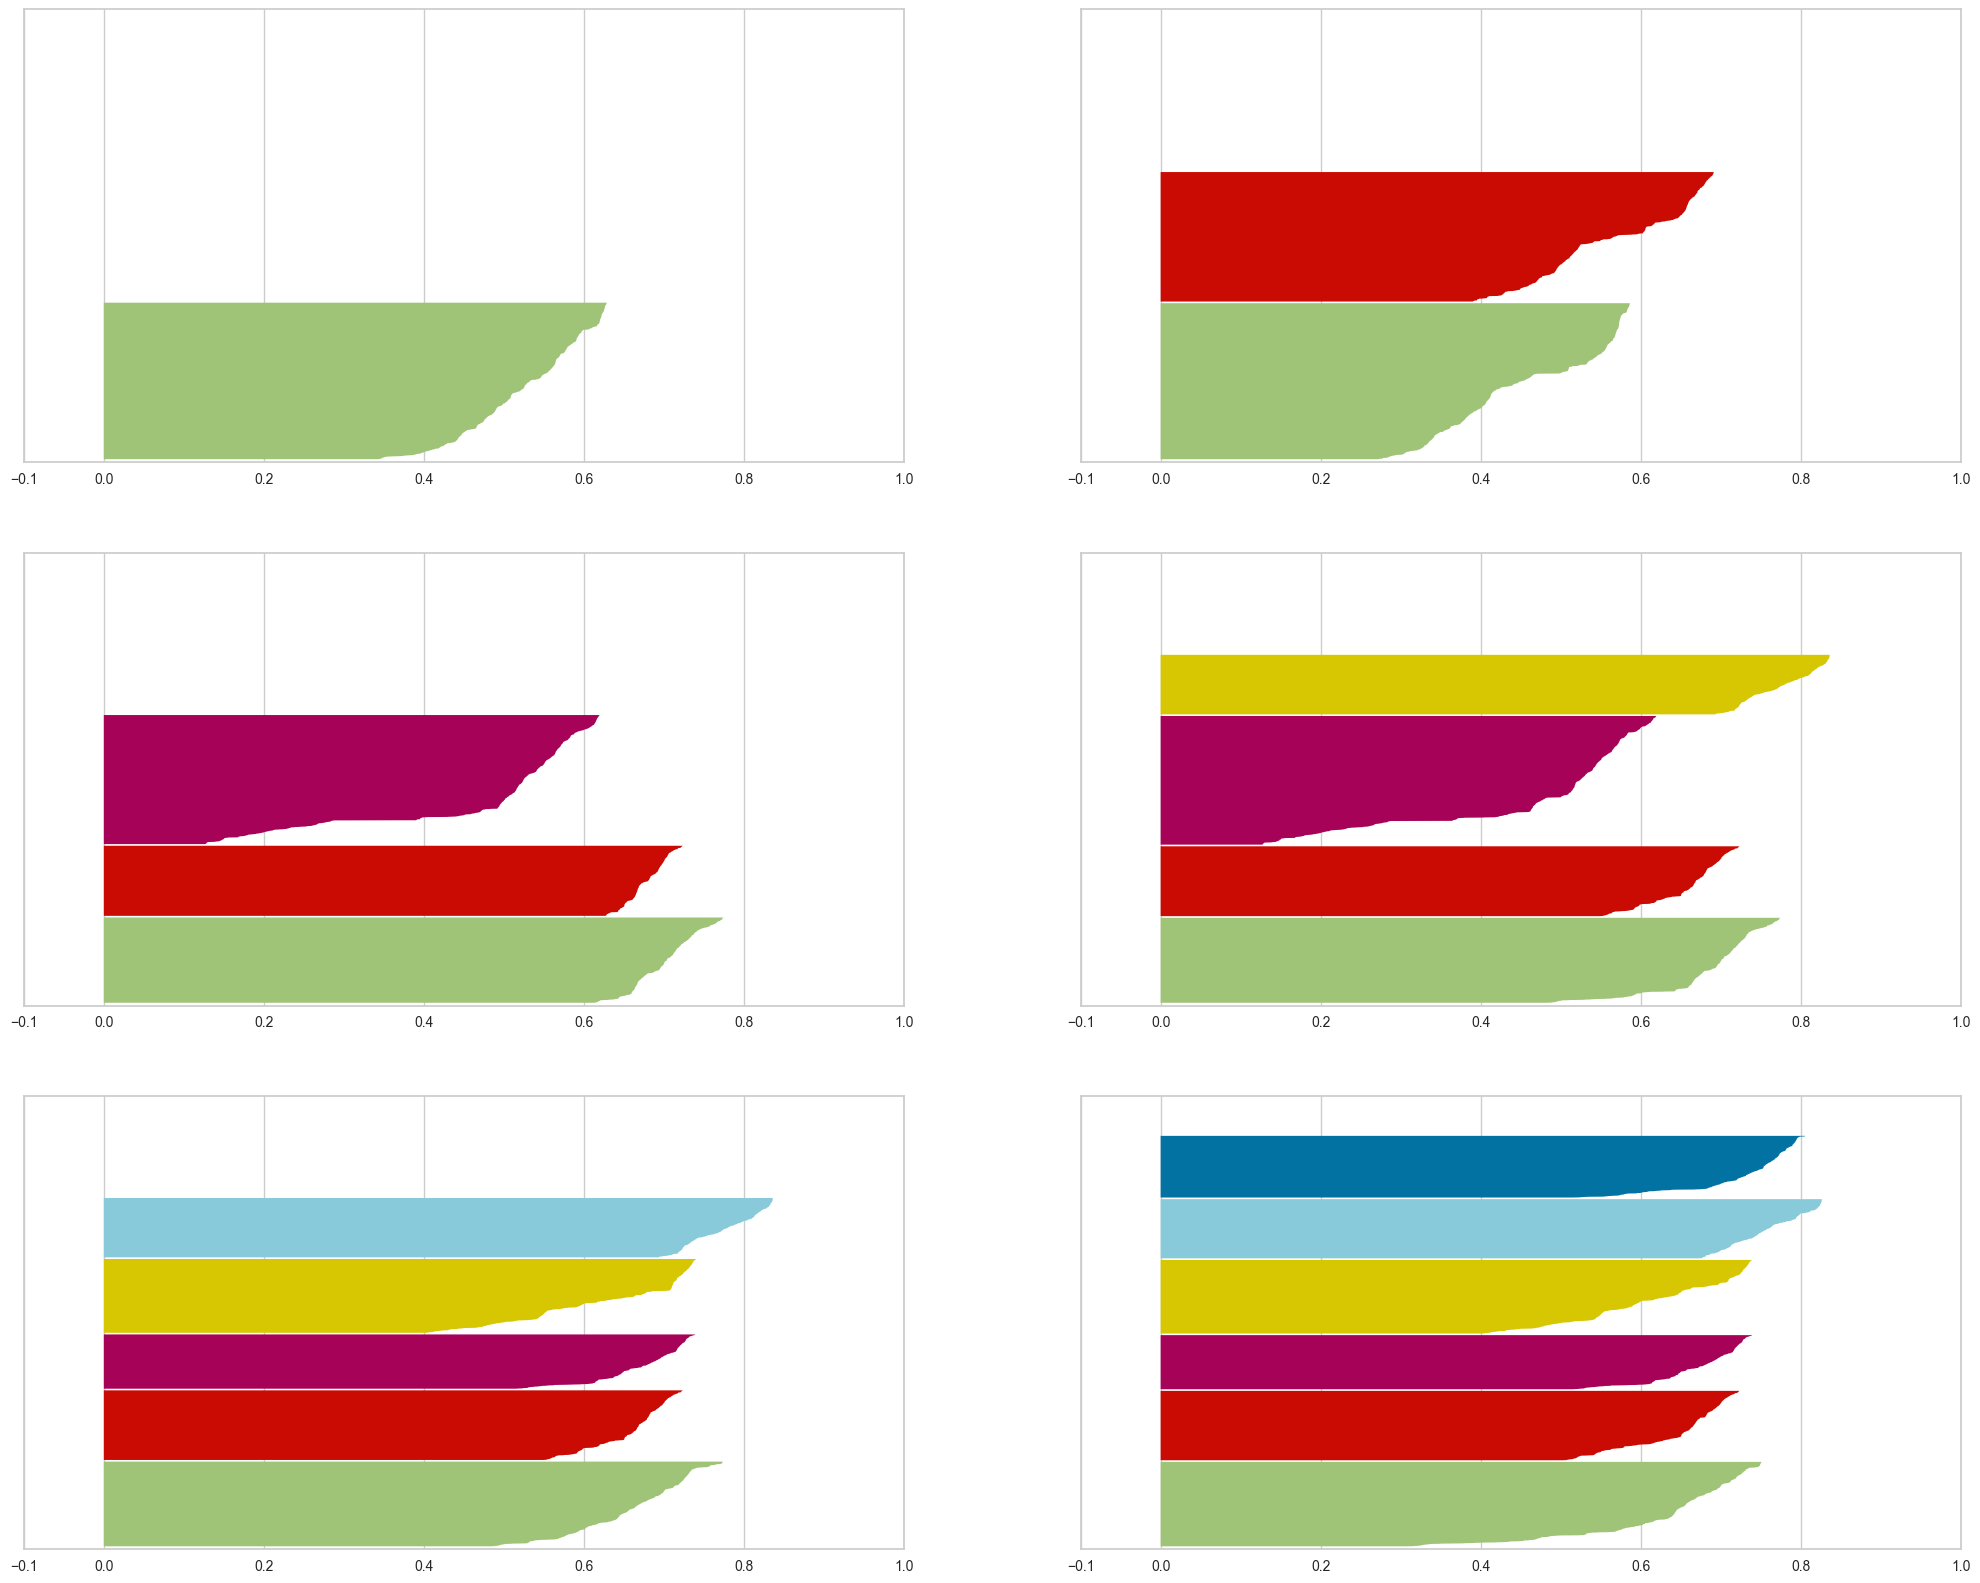

In [72]:
### 7.2.1 Silhouette Analysis
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(25, 20)

clustersx = [2,3,4,5,6,7]
for k in clustersx:
    q, mod = divmod(k, 2)

    ax[q-1, mod].set_xlim( [-0.1, 1] )
    ax[q-1, mod].set_ylim( [0, len(X) + (k+1) * 10] )
    
    # model definition & training
    hc_model = hc.linkage(X, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # performance
    ss = m.silhouette_score(X, labels, metric='euclidean')
    print('For K = {}. Silhouette Score: {}'.format(k, ss))

    samples_silhoette_values = m.silhouette_samples(X, labels)

    y_lower = 10
    for i in range(k):
        # select clusters
        ith_samples_silhouette_values = samples_silhoette_values[labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = plt.colormaps.get_cmap('Spectral')
        color = cmap(i / k)

        ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values)

        y_lower = y_upper + 10

    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 8.0. Model Training

## 8.1 KMeans

In [73]:
# model difnition
k = 7
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.1.1 Cluster Validation

In [74]:
## WSS
print(f'WSS value: {kmeans.inertia_}')

## SS (Silhouette Score)
print('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS value: 23782.314453125
SS value: 0.6735671162605286


# 9.0. Cluster Analysis

In [75]:
df9 = X.copy()
df9['cluster'] = labels
df9['cluster'] = df9['cluster'].astype('int64')
df9.head()

,embedding_x,embedding_y,cluster
0,11.751369,21.327261,4
1,15.552561,16.329659,4
2,-8.372342,8.039770,1
3,3.789669,-8.210548,2
4,1.656555,14.489147,6


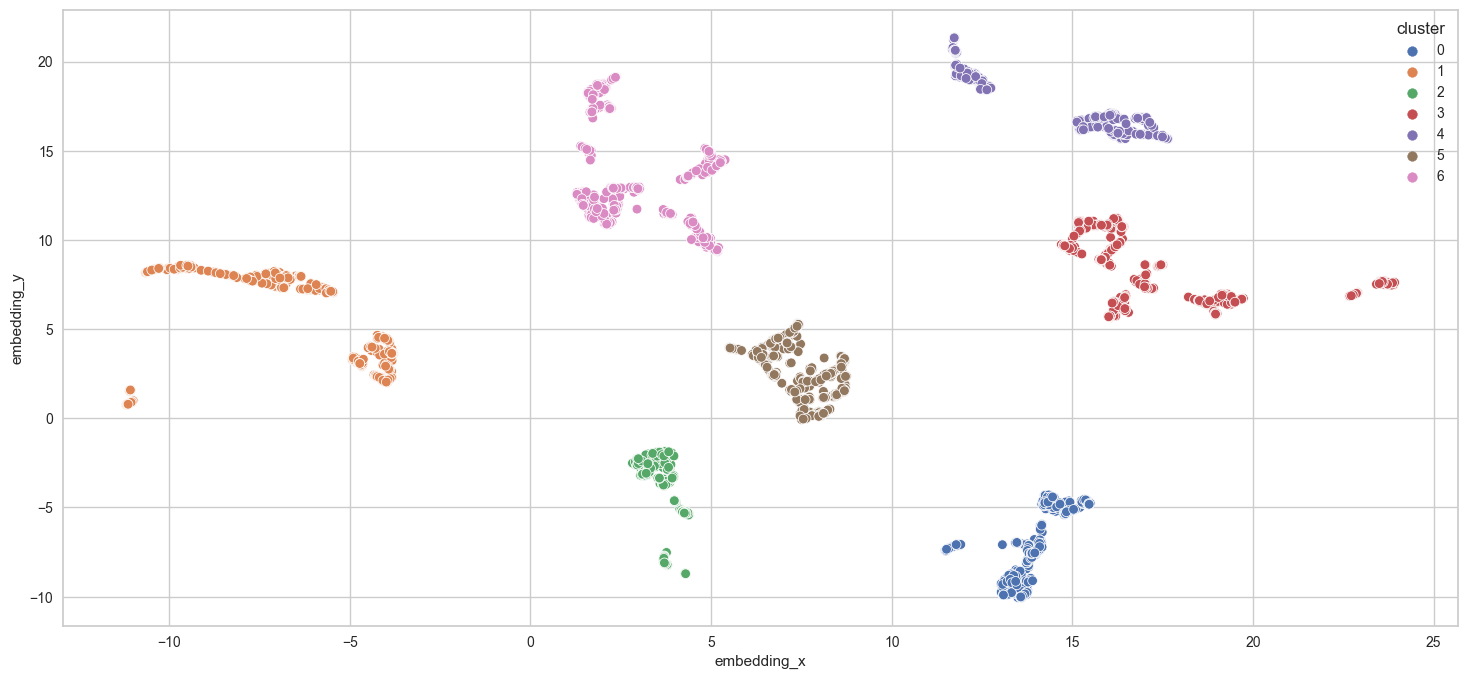

In [76]:
plt.figure(figsize=(18,8))
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep');

## 9.1. Visualization Inspection

c:\Users\Victor\Desktop\repos\pa005_clustering\clustering\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


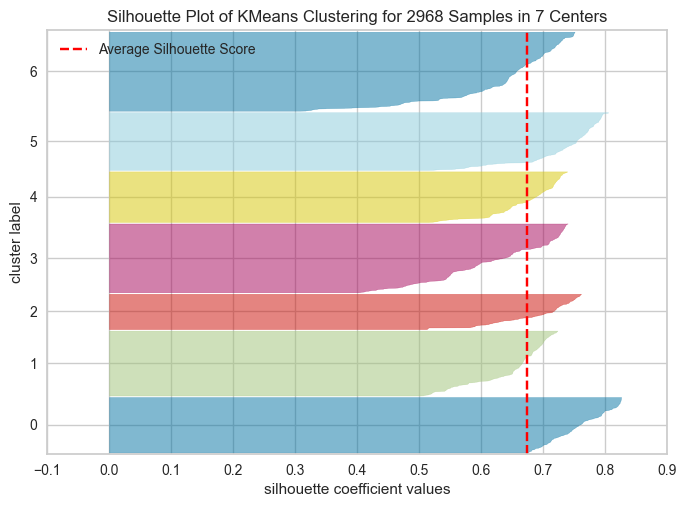

In [77]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize();

### 9.1.1 2d plot

In [78]:
df9 = X.copy()
df9['cluster'] = labels
df9['cluster'] = df9['cluster'].astype('int64')
df9.head()

,embedding_x,embedding_y,cluster
0,11.751369,21.327261,4
1,15.552561,16.329659,4
2,-8.372342,8.039770,1
3,3.789669,-8.210548,2
4,1.656555,14.489147,6


In [79]:
#df_viz = df9.drop(columns='customer_id', axis=1)

#sns.pairplot(df_viz, hue='cluster');

### 9.1.2 UMAP

In [80]:
#reducer = umap.UMAP(n_neighbors= 20,  random_state=42)
#embedding = reducer.fit_transform(X)
#
## embedding
#df_viz['embedding_x'] = embedding[:, 0]
#df_viz['embedding_y'] = embedding[:, 1]
#
## plot
#sns.scatterplot(x='embedding_x', y='embedding_y', data = df_viz, hue='cluster', palette=sns.color_palette('hls', n_colors = len(df_viz['cluster'].unique())));

## 9.2. Cluster Profile

In [81]:
df92 = df4[cols_selected].copy()
df92['cluster'] = labels
df92.head()

,customer_id,gross_revenue,recency_days,qtd_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,0.486111,40.0,4
1,13047,3232.59,56.0,171.0,0.048780,35.0,4
2,12583,6705.38,2.0,232.0,0.045699,50.0,1
3,13748,948.25,95.0,28.0,0.017921,0.0,2
4,15100,876.00,333.0,3.0,0.136364,22.0,6


In [82]:
# Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='left', on='cluster')

# qt products
df_qtde_products = df92[['qtd_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_qtde_products, how='inner', on='cluster')

# Frequency
df_frequency = df92[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_frequency, how='inner', on='cluster')

# Qtde returns
df_qtde_returns = df92[['qtde_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_qtde_returns, how='inner', on='cluster')

In [83]:
df_cluster.sort_values(by='gross_revenue', ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtd_products,frequency,qtde_returns
1,1,468,15.768194,11229.869145,23.799145,357.019231,0.071462,327.707265
4,4,365,12.297844,2601.358877,40.205479,162.654795,0.038478,23.142466
3,3,496,16.711590,1721.961250,41.385081,114.981855,0.038561,21.864919
0,0,399,13.443396,1067.342707,65.411028,72.942356,0.050093,12.107769
2,2,255,8.591644,844.757490,70.278431,63.815686,0.049268,7.070588
5,5,416,14.016173,612.922837,85.954327,50.716346,0.069170,5.069712
6,6,569,19.171159,361.023497,113.748682,24.963093,0.105249,5.521968


In [84]:
### Cluster 

In [87]:
# create table
query_create_table_insiders =  """
    CREATE TABLE insiders (
        customer_id     INTEGER,
        gross_revenue   REAL,
        recency_days    INTEGER,
        qtd_products    INTEGER,
        frequency       REAL,
        qtde_returns    INTEGER,
        cluster         INTEGER
    )
"""

conn = sqlite3.connect('insiders.sqlite')
conn.execute(query_create_table_insiders)
conn.commit()
conn.close()

# insert data
conn = create_engine('sqlite:///insiders.sqlite')
df92.to_sql(name='insiders', con=conn, if_exists='append', index=False)


# consulting database
query = """
    SELECT * FROM insiders
"""

df = pd.read_sql_query(query, conn)

In [88]:
df

,customer_id,gross_revenue,recency_days,qtd_products,frequency,qtde_returns,cluster
0,17850,5391.21,372,297,0.486111,40,4
1,13047,3232.59,56,171,0.048780,35,4
2,12583,6705.38,2,232,0.045699,50,1
3,13748,948.25,95,28,0.017921,0,2
4,15100,876.00,333,3,0.136364,22,6
...,...,...,...,...,...,...,...
2963,12479,473.20,11,30,0.333333,34,2
2964,14126,706.13,7,15,1.000000,50,0
2965,13521,1092.39,1,435,0.300000,0,0
2966,15060,301.84,8,120,2.000000,0,5


# 10.0. Análise Exploratória de Dados

In [85]:
df10 = df92.copy()

## 10.1. MindMap de Hipoteses

1. Fenomeno
2. Entidades (Customer, Location, Finance, Family)
3. Caracteristicas da Entidade (Customer = Nome, Idade, Salario, Escolaridade)

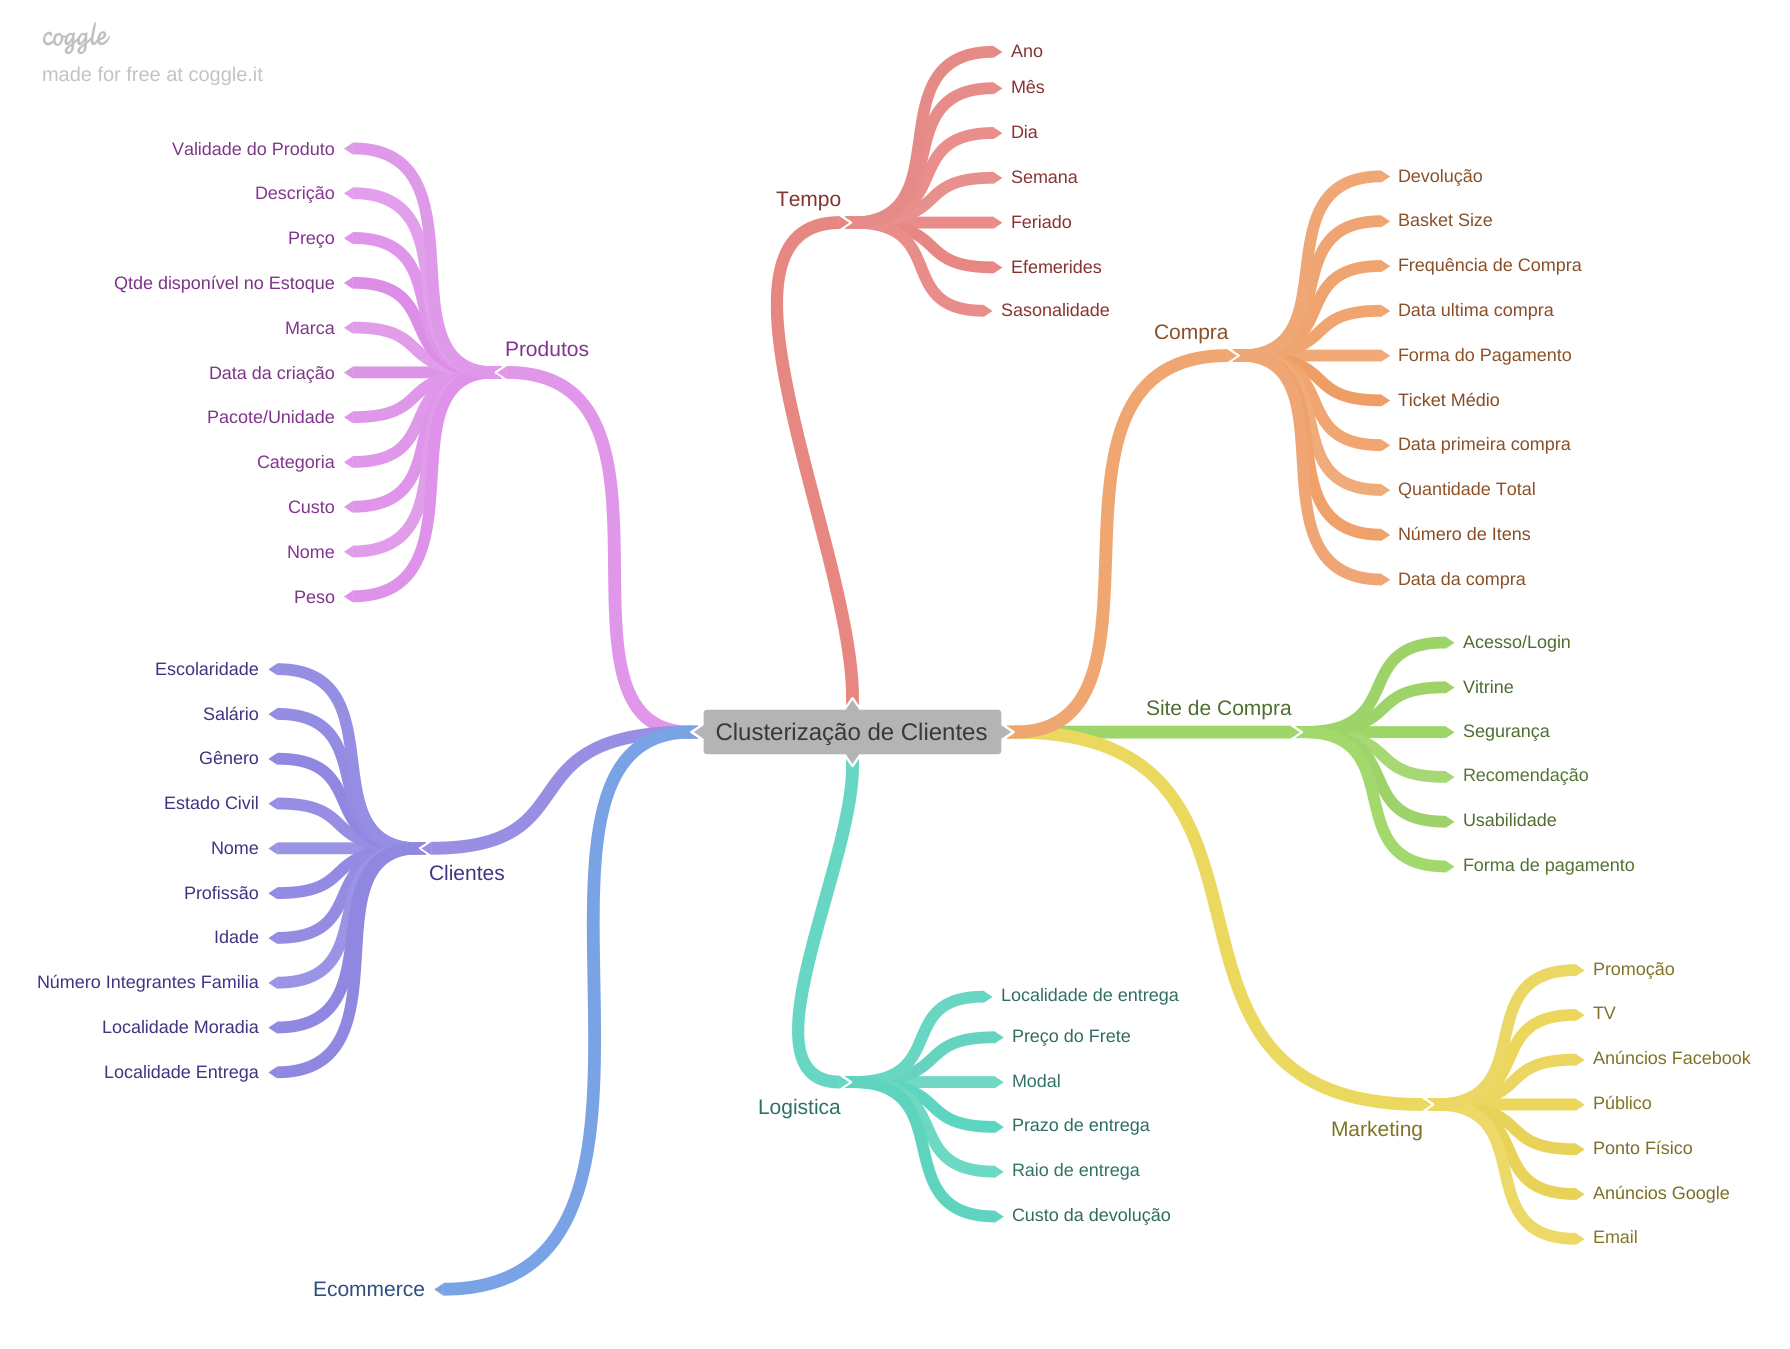

In [86]:
Image('img/clustering_mm.png')

## 10.2. Hipóteses de Negócio

1. Afirmação.
2. Comparação entre variáveis.
3. Valor de base de comparação.

## Hipóteses Compra

1. Os clientes do cluster insiders usam cartão de crédito em 80% das compras.
2. Os clientes do cluster insiders possuem um ticket médio de 10% acima do cluster More Products.
3. Os clientes do cluster insiders possuem um basket size acima de 5 produtos.
4. Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras.
5. Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras.
6. Os clientes do cluster insiders tem um número de devolução abaixo da média da base total de clientes.
7. A mediana do faturamento pelos clientes do cluster insiders é 10% maior do que a mediana do faturamento geral.
8. O percentil do gmv pelos clientes insiders.

### H1. Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras.

**Verdadeiro:** O cluster insiders possue um volume de compra de produtos de 62%

In [87]:
#df10.loc[df10['cluster']==1, ['cluster', 'qtd_products']].groupby('cluster').sum().reset_index()

df_sales_insiders = df10.loc[df10['cluster']==1, 'qtd_products'].sum()
df_sales_total = df10.loc[:, 'qtd_products'].sum()

print('Sales Insiders : {:.2f}%'.format(100*df_sales_insiders / df_sales_total))

Sales Insiders : 45.88%


### H2. Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras.

**Verdadeiro:** O cluster insiders possui um volume de GMV de 76%

In [88]:
df_gmv_insiders = df10.loc[df10['cluster'] == 1, 'gross_revenue'].sum()
df_gmv_total = df10.loc[:, 'gross_revenue'].sum()

print( 'GMV Insiders: {:.2f}%'.format(100*df_gmv_insiders/df_gmv_total))

GMV Insiders: 64.40%


### H3. Os clientes do cluster insiders tem um número de devolução médio abaixo da média da base total de clientes.
**Falso:** O cluster insiders tem a média de devoluções acima da média geral

In [89]:
# media de devolução do cluster insider
df_avg_return_insiders = df10.loc[df10['cluster'] == 1, 'qtde_returns'].mean()

# media de devolução do total
df_avg_returns_all = df10['qtde_returns'].mean()

#
print('Avg Return Insiders: {} vs Avg Return All: {}'.format(np.round(df_avg_return_insiders,0), 
                                                             np.round(df_avg_returns_all,0)))


Avg Return Insiders: 328.0 vs Avg Return All: 62.0


### H4: A mediana do faturamento pelos clientes do cluster insiders é 10% maior do que a mediana do faturamento geral.

In [90]:
# media de gmv do insiders
df_median_gmv_insiders = df10.loc[df10['cluster'] ==1, 'gross_revenue'].median()

# media de gmv do total
df_median_gmv_total = df10.loc[:, 'gross_revenue'].median()

gmv_diff = (df_median_gmv_insiders - df_median_gmv_total) / df_median_gmv_total

print('Median Diff: {:.2f}'.format(100 * gmv_diff))

Median Diff: 393.17


### H5: A quantidade dos clientes insiders estão concentrados no 3 quartil
**Falso:** O faturamento do cluster insiders está concentrada no quartil 1

In [91]:
np.percentile(df10.loc[df10['cluster'] == 1, 'gross_revenue'] , q=0.1)

463.87011000000007

In [92]:
np.percentile(df10.loc[df10['cluster'] == 1, 'gross_revenue'] , q=0.9)

1291.9947200000001

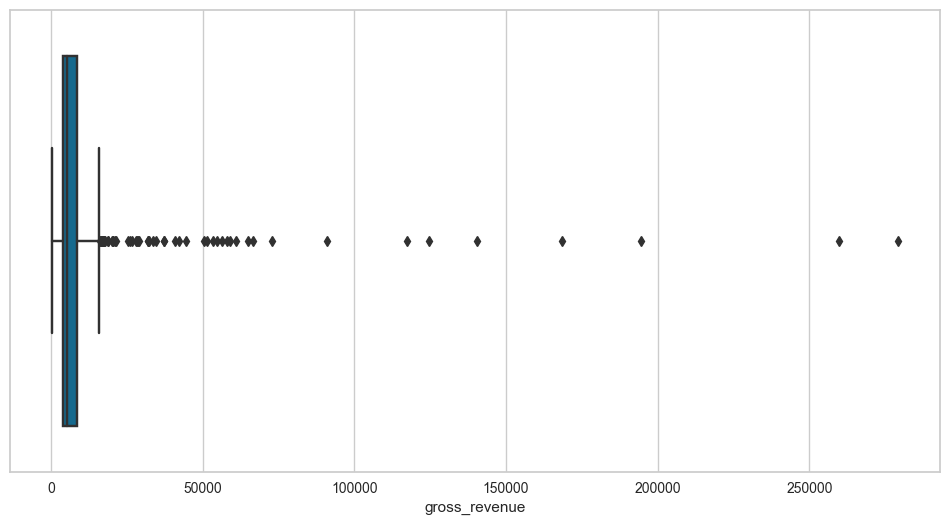

In [93]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df10.loc[df10['cluster']==1, 'gross_revenue']);

## Hipóteses Produto

1. 60% dos clientes do cluster insiders possuem o estado civil de solteiro.
2. 10% dos clientes do cluster insiders estão na faixa de 24-35 anos.
3. 40% das localidades de entrega dos clusters insiders estão dentro de um raio de 50km.
4. 5% dos clientes do cluster insiders recebem mais de 100 mil dólares anualmente.
5. 90% dos clientes do cluster insiders tem ensino superior completo.

## Hipóteses Cliente

1. 30% de todos os produtos em pacotes grandes são comprados pelos clientes do cluster insiders.
2. A mediana dos preços dos produtos comprados pelos clientes do cluster insiders é 10% maior do que a mediana de todos os preços dos produtos.
3. O percentil do preço dos produtos comprados pelos clientes insiders.
4. O peso médio dos produtos comprados pelos clientes do cluster insiders é maior do que o peso médio dos outros clusters.
5. A idade média dos produtos comprados pelos clientes do cluster insiders é maior do que a 15 dias.

## Perguntas de Negócio

1. Quem são as pessoas elegíveis para participar do programa de Insiders?

In [94]:
df10.loc[df10['cluster'] == 1].head()


,customer_id,gross_revenue,recency_days,qtd_products,frequency,qtde_returns,cluster
2,12583,6705.38,2.0,232.0,0.045699,50.0,1
5,15291,4623.30,25.0,102.0,0.054441,29.0,1
6,14688,5630.87,7.0,327.0,0.073569,399.0,1
7,17809,5411.91,16.0,61.0,0.039106,41.0,1
8,15311,60767.90,0.0,2379.0,0.315508,474.0,1


2. Quantos clientes farão parte do grupo?

In [95]:
df10.loc[df10['cluster'] == 1, 'customer_id'].size


468

3. Quais as principais caracteristicas desses clientes?

In [ ]:
# Cluster Insiders
    - Numero de customers:
    - Faturamento Médio:
    - Recência média:
    - Média de Produtos comprados:
    - Frequência de Produtos comprados:
    - Receita em média:

4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders?

In [97]:
df_insiders_gmv = df10.loc[df10['cluster'] == 1, 'gross_revenue'].sum()
df_all_gmv = df10.loc[:, 'gross_revenue'].sum()

print('GMV from Insiders: {}'.format(df_insiders_gmv / df_all_gmv))

GMV from Insiders: 0.6439990438739538


## 10.3. Priorização das Hipóteses

## 10.4. Validação das Hipóteses

## 10.5. Quadro de Respostas